In [1]:
#Append path to Ruomin's Edamame Package (Nanowire Simulations)
import sys
sys.path.append('/import/silo2/aloe8475/Documents/edamame')
saveFig='/import/silo2/aloe8475/Documents/Data/Figures/Equil Prop/'

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.lines as mlines
from matplotlib import colors
import pandas as pd
import skspatial
from skspatial.objects import Plane, Points
from skspatial.plotting import plot_3d

from scipy.io import loadmat, savemat
from scipy import signal

#Import Ruomin's package
from edamame import * 

#import networkx for visualisation of networks
import networkx as nx

#tqdm allows for progress bars
from tqdm.notebook import tqdm_notebook as tqdm

import os
from IPython.core.debugger import set_trace
import matplotlib.colors as clrs


In [3]:
import pickle 
import _pickle as cPickle
import gzip
def compressed_pickle(obj, filename,protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)
def decompress_pickle(file):
    with gzip.open(file, 'rb') as f:
        loaded_object = cPickle.load(f)
        return loaded_object

In [4]:
# GENERATE + LOAD CSV FILE OF IMAGES:
from learning_functions import generate_data, load_data
N= 9
generate_data(N)
inputs,onehot_outputs,sample_num,targets=load_data(N)
target_letters=['z','v','n']
inv_inputs = np.linalg.pinv(inputs)
inputs=inputs[:,:-1]


In [5]:
#SIMPLE ROW INPUTS:
np.random.seed(42)
numSamples=10
orig_inputs=np.array((np.array([1,0,1,1,0,1,0]),np.array([0,1,0,1,1,0,1])))
orig_inputs=orig_inputs.astype('double')
samples=[[] for i in range(len(orig_inputs))]
new_inputs=np.array([orig_inputs]*numSamples)

#Pattern without Noise
NoNoiseInputs=[]
for targetClass in range(len(orig_inputs)):
    NoNoiseInputs.append([int(i) for i in orig_inputs[targetClass]])

#Make Noisy variants of simple patterns:
for i in range(len(orig_inputs)):
    for j in range(numSamples):
        randVals=np.random.randint(1,3) #choose how many of the 3 sources will have noise
        noiseVals=np.random.randint(3, size=randVals)
        temp=orig_inputs[i][orig_inputs[i]==1].astype('double')
        for val in noiseVals:
            temp[val]=np.double(np.random.random(1))
        new_inputs[j][i][new_inputs[j][i]==1]=temp
#         samples[i].append(temp)

#RESHAPE INPUTS INTO 10x3
row1=[]
row2=[]
for i in range(len(new_inputs)):
    row1.append(new_inputs[i][0])
    row2.append(new_inputs[i][1])

inputs=np.array([row1,row2])
inputs=inputs.reshape(20,orig_inputs.shape[1])
targets=np.zeros(20)
targets[-10:]=1

In [6]:
#change 0 volts to 0.05
minVoltage=0.005
#Paramater 1 = baseline input voltages
inputs=inputs+minVoltage
#instead of +ve bias, make it negative

In [7]:
from learning_functions import genGridNW,point_on_line,dist,getWeightedGraph

In [8]:
#load SPARSE network
#Not you need this file in a folder called Sparse Networks 
# asn_nw_00300_nj_00621_seed_1252_avl_10.00_disp_01.00_lx_100.00_ly_100.00
#asn_nw_00350_nj_01400_seed_2665_avl_10.00_disp_01.00_lx_50.00_ly_50.00
#asn_nw_00250_nj_00794_seed_134_avl_10.00_disp_01.00_lx_50.00_ly_50.00
nw=loadmat('/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_00350_nj_01350_seed_1581_avl_10.00_disp_01.00_lx_50.00_ly_50.00')
# nw=loadmat('/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_01399_nj_06084_seed_1159_avl_10.00_disp_01.00_lx_100.00_ly_100.00')
this_seed=8639#np.random.randint(10000) #random seed
Network=nw#edamame.core.generate_network(300,dispersion=350,mean_length=200,this_seed=this_seed)
connectivity=connectivity__(wires_dict=Network) 

In [9]:
#fixing file structure from Matlab:
connectivity.avg_length=connectivity.avg_length[0][0]
connectivity.number_of_junctions=connectivity.number_of_junctions[0][0]
connectivity.centroid_dispersion=connectivity.centroid_dispersion[0][0]
connectivity.dispersion=connectivity.dispersion[0][0]
# connectivity.generating_number_of_wires=connectivity.generating_number_of_wires[0][0]
connectivity.gennorm_shape=connectivity.gennorm_shape[0][0]
connectivity.length_x=connectivity.length_x[0][0]
connectivity.length_y=connectivity.length_y[0][0]
connectivity.number_of_wires=connectivity.number_of_wires[0][0]
connectivity.numOfWires=connectivity.numOfWires[0][0]
connectivity.numOfJunctions=connectivity.numOfJunctions[0][0]
connectivity.theta=connectivity.theta[0][0]
connectivity.this_seed=connectivity.this_seed[0][0]

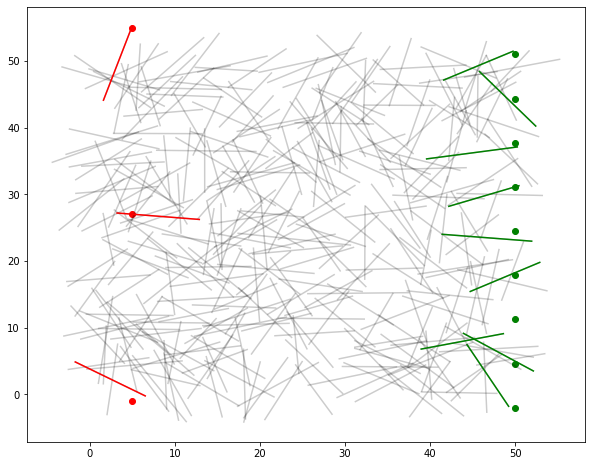

In [10]:
#Generate Network
%matplotlib inline

#find x and y values of each end of each wire 
xa=connectivity.xa[0]
xb=connectivity.xb[0]
ya=connectivity.ya[0]
yb=connectivity.yb[0]

#Pick Electrode placement/distance apart:

#DRAINS
numDrains=3
ex=np.ones(numDrains)*5#*15
# ey=np.linspace(0,550,numDrains)
ey=np.linspace(-1,55,numDrains)#(-1,101,numDrains)

elecDrain=genGridNW(xa,xb,ya,yb,ex,ey) #generate drain locations in ex, ey coordinates

plt.figure(figsize=(10,8))
plt.scatter(ex, ey, c = 'r')

#SOURCES
numSources=9

#IN A LINE:
ex=np.ones(numSources)*50#50
ey=np.linspace(-2,51,numSources)#(-2,99,numSources)
#IN A 3X3 GRID:
# middleNWx=int(connectivity.length_x/2)+1
# middleNWy=int(connectivity.length_y/2)-1
# distBwElecs=10
# ex=[middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx,middleNWx,middleNWx,middleNWx+distBwElecs,middleNWx+distBwElecs,middleNWx+distBwElecs]
# ey=[middleNWy-distBwElecs,middleNWy,middleNWy+distBwElecs]*3

elecSource=genGridNW(xa,xb,ya,yb,ex,ey) #generate source locations in ex, ey coordinates

plt.plot([xa, xb], [ya, yb], c = 'k',alpha=0.2)
plt.plot([xa[elecDrain], xb[elecDrain]], [ya[elecDrain], yb[elecDrain]], c = 'r')
plt.plot([xa[elecSource], xb[elecSource]], [ya[elecSource], yb[elecSource]], c = 'g')

plt.scatter(ex, ey, c = 'g')

# plt.savefig(figLoc+'Network and Electrodes.png',dpi=300)

In [11]:
print('OG Sources:' + str(elecSource))
print('OG Drains:' + str(elecDrain))


#remove middle drain and sources for simple patterns:

elecSource=elecSource[[0,1,2,4,6,7,8]]
elecDrain=elecDrain[[0,-1]]

print('New Sources:' + str(elecSource))
print('New Drains:' + str(elecDrain))


OG Sources:[183 322 194  42 145 161 129 342 108]
OG Drains:[296 331 102]
New Sources:[183 322 194 145 129 342 108]
New Drains:[296 102]


In [12]:
#LOAD DATA
dataLoc='/import/silo2/aloe8475/Documents/Data/Associative Learning/Results/'

In [13]:
allAmpsTraining = [0.5,1,2,5] #Input voltage training
allAmpsTesting  = [0.2,0.3,0.5] #Input voltage testing

In [14]:
results=[]
for i in allAmpsTraining:
    for j in allAmpsTesting:
        file = open(dataLoc+"EquilPropVoltageSweep"+str(i)+str(j)+".pkl",'rb')
        results.append(pickle.load(file))


In [16]:
sims=[]
currents=[]
for r in results:
    sims.append(r[0])
    currents.append(r[1])

In [17]:
sims[0].wireVoltage.shape

(600, 1399)

In [18]:
allAmpsTraining = [0.5,1,2,5] #Input voltage training
allAmpsTesting  = [0.1,0.2,0.3] #Input voltage testing
onAmp=[]
onAmpTest=[]
for trainAmp in tqdm(range(len(allAmpsTraining))):
    for testAmp in tqdm(range(len(allAmpsTesting))):
        onAmp.append(allAmpsTraining[trainAmp])
        onAmpTest.append(allAmpsTesting[testAmp])
        


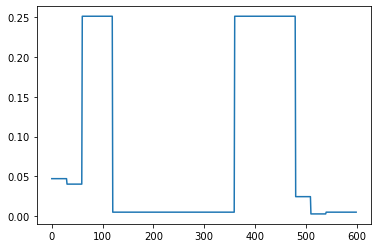

In [19]:
plt.plot(sims[0].stimulus[2].signal)

In [20]:
sequences = [1122,2211,1221,2112,1212,2121]
this_seq  = 2

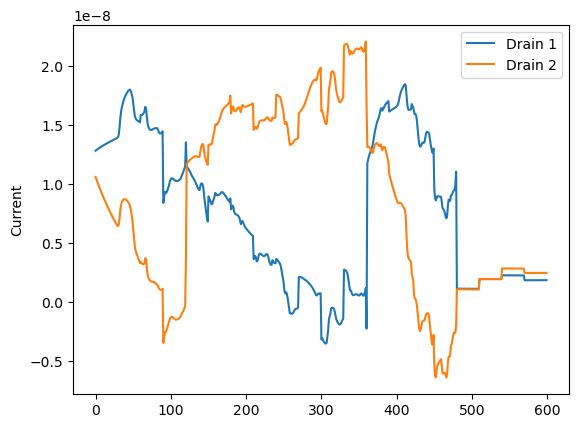

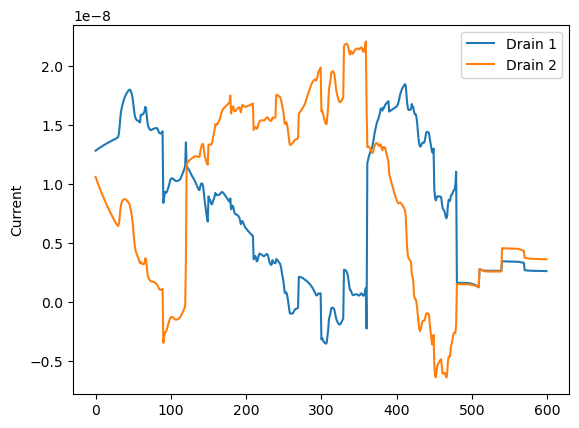

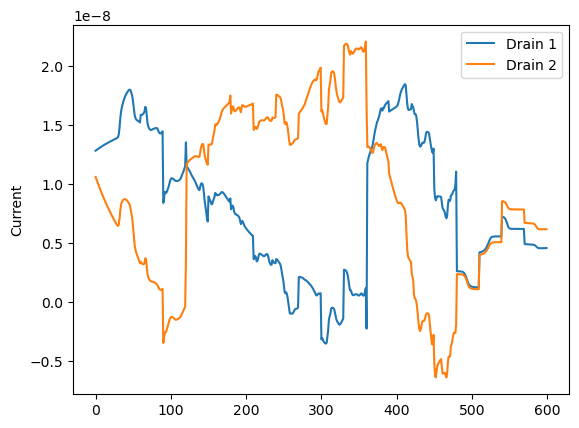

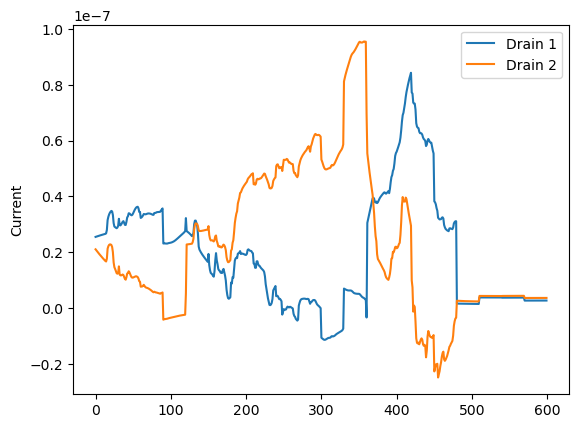

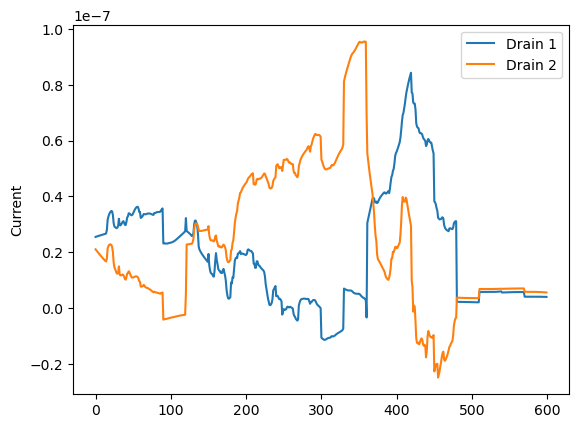

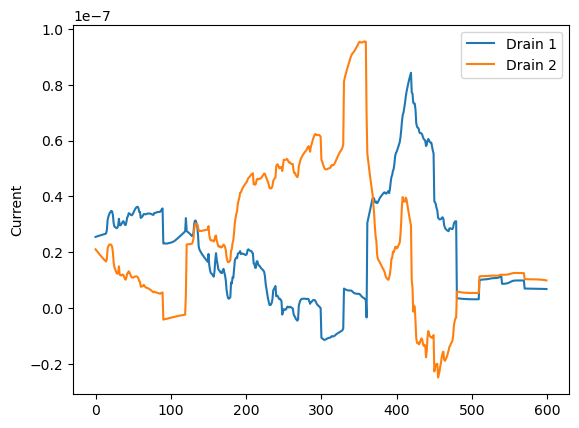

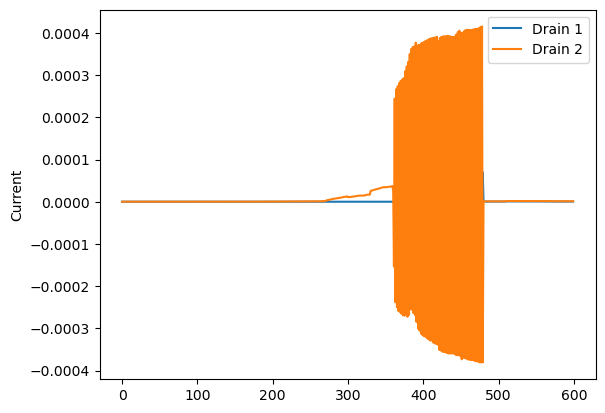

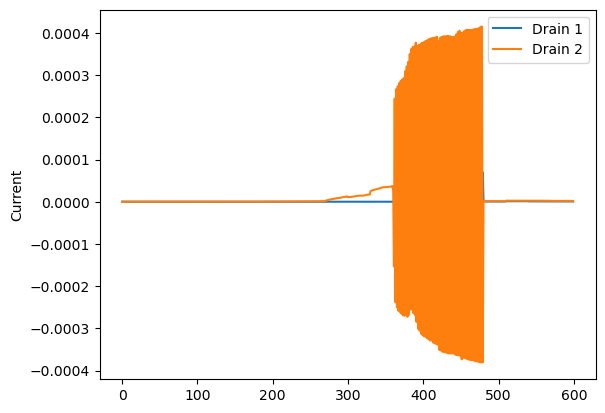

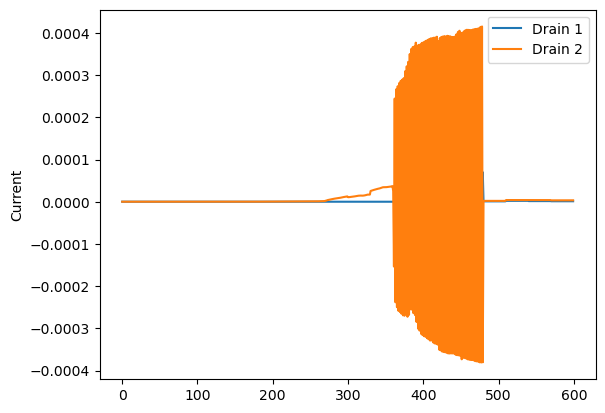

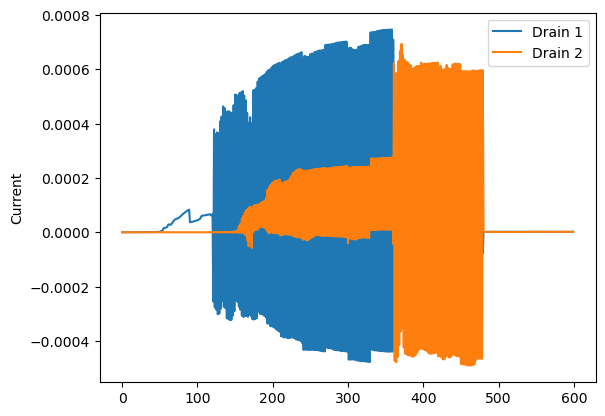

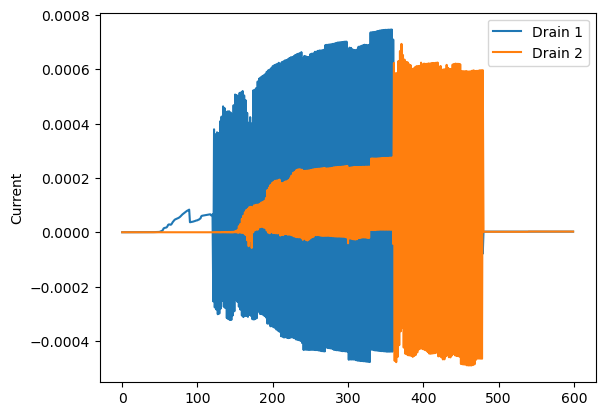

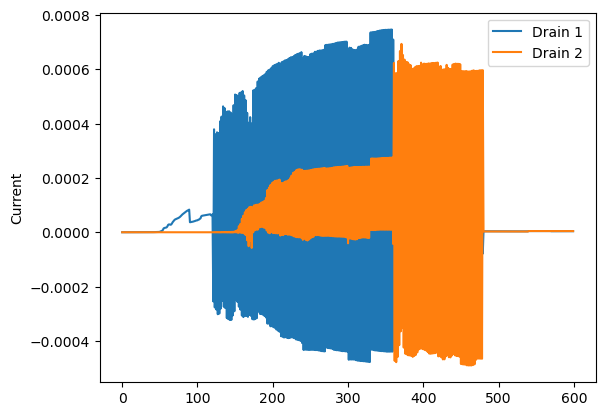

In [22]:
#DATA ANALYSIS
plt.rcParams.update(plt.rcParamsDefault)

i=0
j=0
for current in tqdm(currents):
    plt.figure()
    plt.plot(current[0])
    plt.plot(current[1])
    # plt.plot(t[2])
    plt.legend(['Drain 1','Drain 2'])#,'Drain 3'])
    plt.ylabel('Current')
    # plt.vlines((trainTime),-2e-5,6e-5,color='k',linestyles='--')
    # plt.vlines((trainTime+(testTime/2)),-2e-5,6e-5,color='k',linestyles='--')
    # plt.vlines((trainTime+testTime),-2e-5,6e-5,color='k',linestyles='--')

    # plt.xlim([36000,45000])
    
    trainAmp=onAmp[i]
    testAmp=onAmpTest[i]
    i+=1
    # print(labels)
    plt.savefig(saveFig+'2 classes_'+str(trainAmp)+'V_testing '+str(testAmp)+'V_overlap pattern '+str(sequences[this_seq])+'_beta 01_current.png')

In [35]:
restDur=0
numDT=30
numTrainingSamples = 16
numTestingSamples = 4

trainTime  = numTrainingSamples*(numDT+restDur)
testTime   = numTestingSamples*(numDT+restDur)


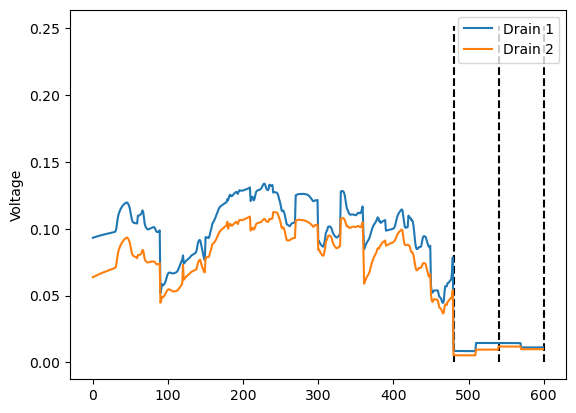

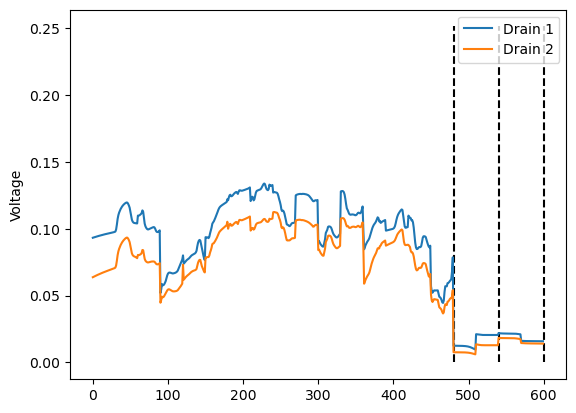

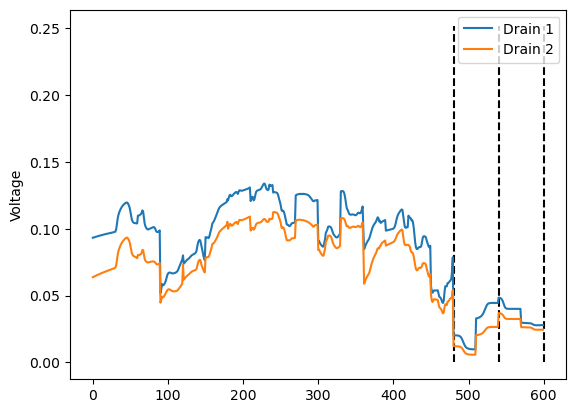

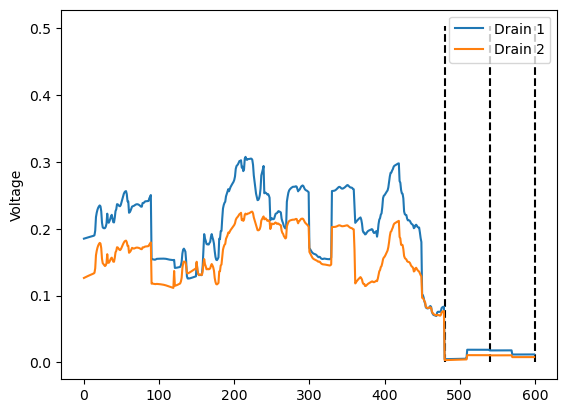

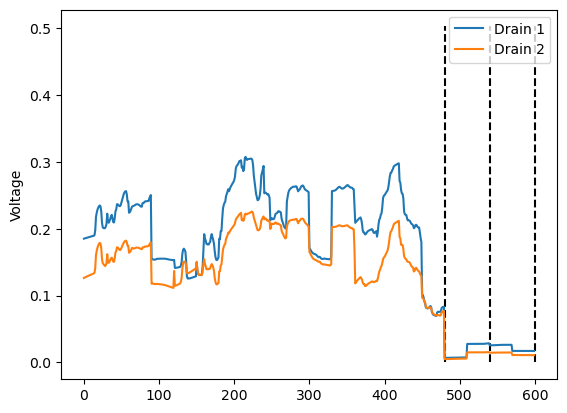

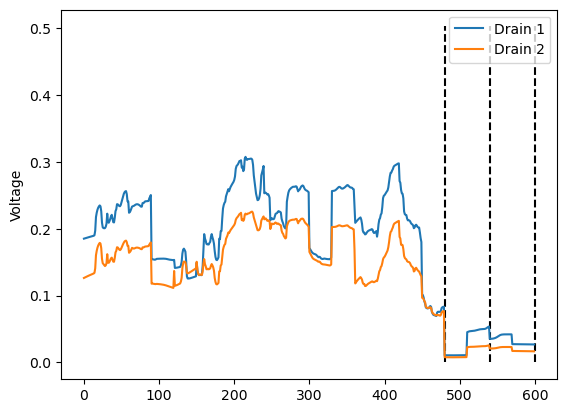

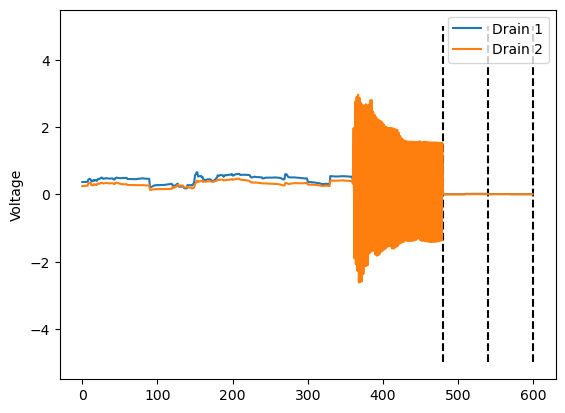

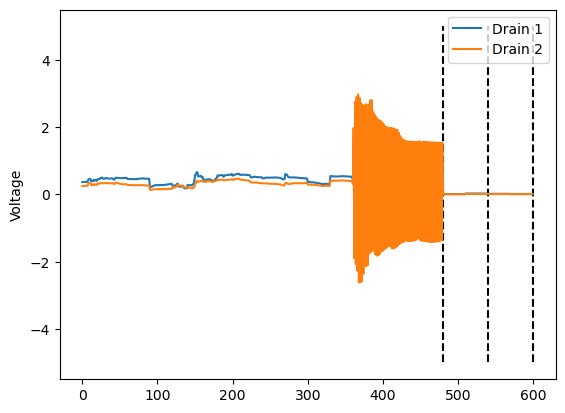

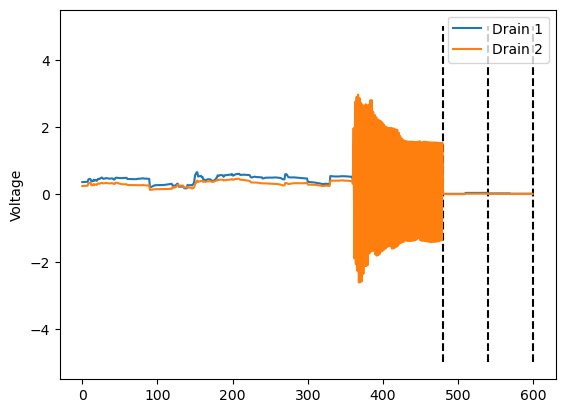

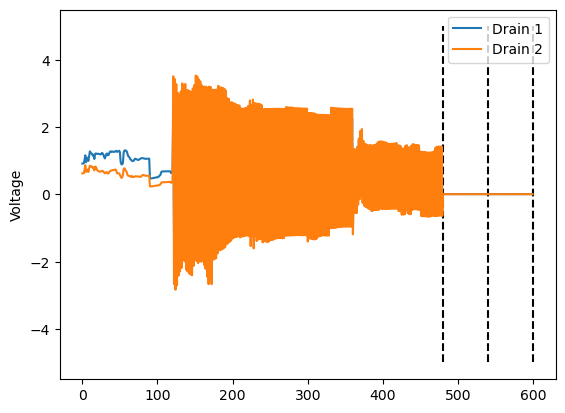

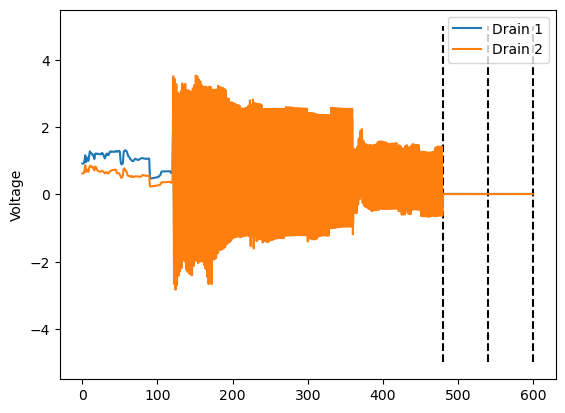

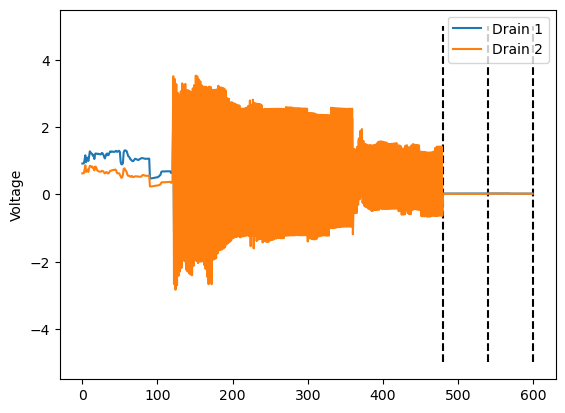

In [36]:
plt.rcParams.update(plt.rcParamsDefault)

i=0
for sim in tqdm(sims):
    plt.figure()
    plt.plot(sim.wireVoltage[:,elecDrain[0]])
    plt.plot(sim.wireVoltage[:,elecDrain[1]])

    # plt.plot(t[2])
    plt.legend(['Drain 1','Drain 2'])#,'Drain 3'])
    plt.ylabel('Voltage')
    plt.vlines((trainTime),np.min(sim.wireVoltage),np.max(sim.wireVoltage),color='k',linestyles='--')
    plt.vlines((trainTime+(testTime/2)),np.min(sim.wireVoltage),np.max(sim.wireVoltage),color='k',linestyles='--')
    plt.vlines((trainTime+testTime),np.min(sim.wireVoltage),np.max(sim.wireVoltage),color='k',linestyles='--')

    # plt.xlim([36000,45000])
    trainAmp=onAmp[i]
    testAmp=onAmpTest[i]
    # print(labels)
    
    plt.savefig(saveFig+'2 classes_'+str(trainAmp)+'V_testing '+str(testAmp)+'V_overlap pattern '+str(sequences[this_seq])+'_beta 01_critFlux 1e-1_Voltage.png')
    
    i+=1

In [37]:
plt.plot(tmpTargets,c='b')
plt.plot(np.argmax([t[0],t[1]],axis=0),alpha=0.5,c='r')
plt.legend(['Target','Argmax'])
plt.vlines((trainTime),0,1,color='k',linestyles='--')
# plt.vlines((trainTime+(testTime/2)),0,1,color='k',linestyles='--')
plt.vlines((trainTime+testTime),0,1,color='k',linestyles='--')
plt.yticks([0,1])
ax=plt.gca()
ax.set_yticklabels(['Drain 1','Drain 2'])
plt.savefig(saveFig+'2 classes_'+str(onAmp)+'V_testing '+str(onAmpTest)+'V_overlap pattern '+str(sequences[this_seq])+'_beta 01_critFlux 1e-1_argmax vs target.png')

NameError: name 'tmpTargets' is not defined